In [17]:
import pandas as pd
import numpy as np
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv1D, Flatten, MaxPooling1D, Embedding, GlobalMaxPooling1D, Dropout, Input
import matplotlib.pyplot as plt
from util import plot_history
import feature_builder
from sklearn.model_selection import GridSearchCV

Cargo datasets

In [2]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

Armo features con el feature_builder

In [3]:
def prepare_for_cnn(df):
    processed = feature_builder.process_dataset(df)
    to_numpy = processed.to_numpy()
    to_numpy = to_numpy.reshape(processed.shape[0], processed.shape[1], 1)
    return to_numpy

In [7]:
%%time
X_train = prepare_for_cnn(train_df)
y_train = train_df['target'].values

Percentage of words covered in the embeddings = 0.6336399642263958
Wall time: 41.5 s


Creo el modelo y corro la CNN

In [21]:
def create_model(filters, kernel_sizes, pool_sizes, units, cnn_layers, dense_layers):
    model = Sequential()
    model.add(Input(shape=(X_train.shape[1], X_train.shape[2])))
    
    for i in range(cnn_layers):
        model.add(Conv1D(filters=filters[i], kernel_size=kernel_sizes[i], activation='relu'))
        model.add(MaxPooling1D(pool_sizes[i]))

    model.add(Flatten())
    
    for i in range(dense_layers):
        model.add(Dense(units[i], activation='relu'))

    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
    
    return model

In [14]:
filters=[128,128]
kernel_size=[5,5]
pool_sizes=[2,2]
units=[64, 64]
cnn_layers=2
dense_layers=2

In [22]:
filters=[32,32,64]
kernel_size=[3,3,3]
pool_sizes=[2,2,2]
units=[64]
cnn_layers=3
dense_layers=1

Epoch 1/60
319/319 [==============================] - 3s 8ms/step - loss: 0.7034 - accuracy: 0.5594 - val_loss: 0.6790 - val_accuracy: 0.5635
Epoch 2/60
319/319 [==============================] - 3s 8ms/step - loss: 0.6911 - accuracy: 0.5710 - val_loss: 0.6753 - val_accuracy: 0.5515
Epoch 3/60
319/319 [==============================] - 2s 8ms/step - loss: 0.6803 - accuracy: 0.5761 - val_loss: 0.6738 - val_accuracy: 0.5515
Epoch 4/60
319/319 [==============================] - 2s 8ms/step - loss: 0.6781 - accuracy: 0.5765 - val_loss: 0.6625 - val_accuracy: 0.5515
Epoch 5/60
319/319 [==============================] - 2s 7ms/step - loss: 0.6827 - accuracy: 0.5761 - val_loss: 0.6697 - val_accuracy: 0.5515
Epoch 6/60
319/319 [==============================] - 2s 7ms/step - loss: 0.6822 - accuracy: 0.5745 - val_loss: 0.6575 - val_accuracy: 0.5515
Epoch 7/60
319/319 [==============================] - 3s 8ms/step - loss: 0.6843 - accuracy: 0.5796 - val_loss: 0.6886 - val_accuracy: 0.5515
Epoch 

319/319 [==============================] - 2s 8ms/step - loss: 0.4656 - accuracy: 0.7631 - val_loss: 0.5066 - val_accuracy: 0.7772
Epoch 59/60
319/319 [==============================] - 2s 8ms/step - loss: 0.4603 - accuracy: 0.7673 - val_loss: 0.5160 - val_accuracy: 0.7716
Epoch 60/60
319/319 [==============================] - 2s 8ms/step - loss: 0.4575 - accuracy: 0.7663 - val_loss: 0.5132 - val_accuracy: 0.7740


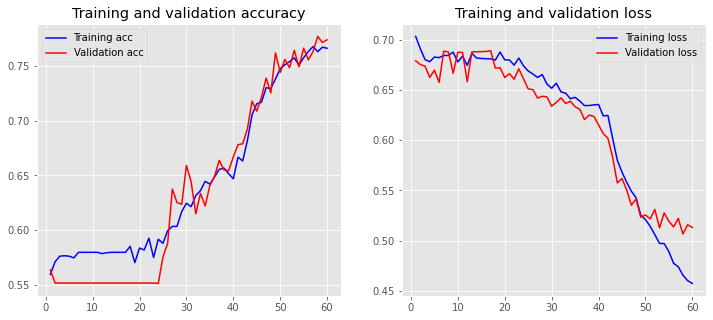

In [23]:
model = create_model(
    filters=filters,
    kernel_sizes=kernel_size,
    pool_sizes=pool_sizes,
    units=units,
    cnn_layers=cnn_layers,
    dense_layers=dense_layers
)
history = model.fit(X_train, y_train, epochs=60, shuffle=False, validation_split=0.33, batch_size=16)
plot_history(history)

Calculemos el test para kaggle

In [ ]:
ids = test_df['id']

final_test = prepare_for_cnn(test_df)
prediction = model.predict_classes(final_test)

final_df = pd.DataFrame({'target': [x[0] for x in prediction]}, index=ids)
final_df

In [ ]:
final_df['target'].value_counts()

In [ ]:
final_df.count()

In [ ]:
final_df.to_csv('cnn.csv')

In [ ]:
model = KerasClassifier(build_fn=create_model, verbose=False, epochs=25)

filters = [32,64,128,1024,10000]
kernel_size = [2,3,5]
units = [64,128]

param_grid = dict(filters=filters,kernel_size=kernel_size,units=units)# 
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1)

#Run grid search
grid_result = grid.fit(X_train, y_train)

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

In [ ]:
filters=[32,32,64]
kernel_size=[3,3,3]
pool_sizes=[2,2,2]
units=[[64], [64, 64], [64, 32]]
cnn_layers=[1,2,3,4]
dense_layers=[1,2]